<a href="https://colab.research.google.com/github/gmarianini/TFG_ECG_Arrhythmia_Detection/blob/main/TFG_V2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Detección de Arritmias ECG en Tiempo Real con TensorFlow Lite y Raspberry Pi

Este cuaderno implementa un sistema completo para la detección de arritmias cardíacas a partir de señales de ECG. El flujo de trabajo abarca desde la preparación y aumento de datos, el entrenamiento de un modelo de Red Neuronal Multicapa (MLP) utilizando TensorFlow/Keras, hasta la validación del modelo y su optimización para despliegue en dispositivos de borde como la Raspberry Pi (utilizando TensorFlow Lite).

**Objetivos Principales:**

1.  **Preprocesamiento y Aumento de Datos:** Manejar señales de ECG crudas y enriquecer el dataset con técnicas como el jitter y la inyección de ruido para mejorar la robustez del modelo.
2.  **Entrenamiento de Modelo MLP:** Construir y entrenar una red neuronal densa para clasificar latidos como 'normales' o 'arrítmicos', incorporando el intervalo RR como característica adicional.
3.  **Validación y Evaluación:** Evaluar el rendimiento del modelo en un conjunto de datos de prueba 'desconocido' y en una base de datos externa (INCART) para simular un escenario real.
4.  **Optimización para Edge Computing:** Convertir el modelo entrenado a formato TensorFlow Lite para su despliegue eficiente en microcontroladores y dispositivos IoT.
5.  **Simulación en Tiempo Real:** Demostrar cómo el modelo podría funcionar en un entorno de streaming de datos, detectando arritmias con baja latencia.

### 1. Configuración del Entorno y Librerías

Primero, instalamos las librerías necesarias para la carga de datos (wfdb), manipulación numérica (numpy), graficación (matplotlib, seaborn), preprocesamiento (scipy, scikit-learn) y construcción del modelo (tensorflow/keras).

In [ ]:
!pip install wfdb matplotlib numpy scikit-learn tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 108.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.


### 2. Montar Google Drive (Opcional)

Montamos Google Drive para poder guardar los modelos entrenados y otros archivos generados de forma persistente. Si no deseas guardar los archivos en Drive, puedes omitir esta celda y modificar las rutas de guardado a `/content/`.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


### 3. Importar Librerías y Configuración Global

Aquí importamos todas las librerías necesarias para el procesamiento de datos, modelado y visualización. También definimos constantes globales como la frecuencia de muestreo (`FS_OBJETIVO`) y el tamaño de la ventana de procesamiento (`WINDOW_SIZE`), así como el mapeo de los símbolos de latidos normales de la base de datos MIT-BIH.

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random
import seaborn as sns

# Configuración
FS_OBJETIVO = 360  # MIT-BIH es 360Hz.
WINDOW_SECONDS = 0.6 # 600ms de ventana
WINDOW_SIZE = int(WINDOW_SECONDS * FS_OBJETIVO)

# Mapeo de clases (Simplificado a Binario para empezar)
# 0: Normal, 1: Arritmia
NORMAL_SYMBOLS = ['N', 'L', 'R', 'e', 'j']

### 4. División de Registros MIT-BIH

Dividimos los registros de la base de datos MIT-BIH en conjuntos de entrenamiento y prueba. Es crucial reservar un conjunto de registros de prueba ('desconocidos') para una validación final que simule un escenario real de despliegue, donde el modelo se enfrenta a datos de pacientes que nunca ha visto.

In [ ]:
# Lista completa de registros MIT-BIH
todos_registros = [
    '100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
    '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
    '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
    '209', '210', '212', '213', '214', '215', '219', '220', '221', '222',
    '223', '228', '230', '231', '232', '233', '234'
]

# Reservamos el ~20% para VALIDACIÓN FINAL (Simulación Raspberry)
# Estos pacientes son "desconocidos" para la IA.
registros_test = ['102', '104', '115', '117', '207', '209', '214', '222', '230', '234']

# El resto para ENTRENAR
registros_train = [r for r in todos_registros if r not in registros_test]

print(f"Pacientes para ENTRENAR: {len(registros_train)}")
print(f"Pacientes para TEST (Simulación): {len(registros_test)}")

Pacientes para ENTRENAR: 37
Pacientes para TEST (Simulación): 10


### 5. Preparación del Dataset Inicial (Solo Forma de Onda)

La función `crear_dataset` procesa las señales ECG, aplicando filtros pasa-banda y normalización Z-score. Extrae segmentos centrados en los picos R y los etiqueta como 'Normal' o 'Arritmia'. Además, incorpora **aumento de datos (data augmentation)** para la clase normal inyectando ruido, lo que ayuda a que el modelo sea más robusto a las fluctuaciones del sensor.

In [ ]:
def filtro_bandpass(data, lowcut=0.5, highcut=100.0, fs=360, order=2):
    """Filtro pasa banda para eliminar ruido muscular y deriva de línea base."""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def agregar_ruido(segmento):
    """Inyecta ruido gaussiano para hacer el modelo robusto."""
    noise_level = np.random.uniform(0.02, 0.10) * np.max(segmento)
    noise = np.random.normal(0, noise_level, segmento.shape)
    return segmento + noise

def crear_dataset(lista_registros):
    X_list = []
    y_list = []

    print(f"Procesando {len(lista_registros)} registros...")

    for record_id in lista_registros:
        try:
            # Cargar señal y anotaciones
            record = wfdb.rdrecord(record_id, pn_dir='mitdb')
            annotation = wfdb.rdann(record_id, 'atr', pn_dir='mitdb')

            # Usar canal 0 y FILTRAR (Crucial para consistencia con AD8232)
            signal = record.p_signal[:, 0]
            signal = filtro_bandpass(signal, fs=record.fs)

            # Recorrer anotaciones
            for i, sample in enumerate(annotation.sample):
                symbol = annotation.symbol[i]
                if symbol in ['+', '~', '!', '[', ']', '|', '"']: continue # Ignorar no-latidos

                label = 0 if symbol in NORMAL_SYMBOLS else 1

                # Extraer ventana centrada
                start = sample - (WINDOW_SIZE // 2)
                end = sample + (WINDOW_SIZE // 2)

                if start < 0 or end > len(signal): continue

                segment = signal[start:end]

                # Normalización Z-Score (Estándar para ML en biosignals)
                if np.std(segment) < 0.001: continue # Evitar líneas planas
                segment = (segment - np.mean(segment)) / np.std(segment)

                X_list.append(segment)
                y_list.append(label)

                # --- DATA AUGMENTATION ---
                # Si es NORMAL, agregamos una copia con RUIDO para enseñar al modelo
                # que "Ruido" no es igual a "Arritmia".
                if label == 0 and random.random() < 0.5: # 50% de probabilidad
                    noisy = agregar_ruido(segment)
                    X_list.append(noisy)
                    y_list.append(0) # Sigue siendo clase 0 (Normal)

        except Exception as e:
            print(f"Error cargando {record_id}: {e}")

    X = np.array(X_list)
    y = np.array(y_list)

    # BALANCEO FINAL (Downsampling de clase mayoritaria si es necesario)
    # Seleccionamos todos los de clase 1 y una cantidad igual de clase 0 aleatoria
    idx_0 = np.where(y == 0)[0]
    idx_1 = np.where(y == 1)[0]

    n_samples = min(len(idx_0), len(idx_1))

    idx_0_sel = np.random.choice(idx_0, n_samples, replace=False)
    idx_1_sel = np.random.choice(idx_1, n_samples, replace=False)

    indices = np.concatenate([idx_0_sel, idx_1_sel])
    np.random.shuffle(indices)

    return X[indices], y[indices]

# Ejecutar la creación del dataset
X_train, y_train = crear_dataset(registros_train)

# Split interno para validar durante el entrenamiento (curvas de loss)
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

print("\nDataset Listo:")
print(f"Train shape: {X_train_final.shape}")
print(f"Val shape: {X_val_final.shape}")

Procesando 37 registros...

Dataset Listo:
Train shape: (19908, 216)
Val shape: (3514, 216)


### 6. Construcción y Entrenamiento del Modelo MLP Inicial

Definimos una Red Neuronal Multicapa (MLP) con capas densas, normalización por lotes (`BatchNormalization`) y regularización por abandono (`Dropout`) para mejorar la estabilidad y evitar el sobreajuste. El modelo se entrena con los datos preparados, utilizando *Early Stopping* y *Model Checkpointing* para guardar el mejor modelo y prevenir el sobreentrenamiento.

In [ ]:
def construir_mlp_robusto(input_dim):
    model = Sequential([
        # Capa de entrada
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(), # Normaliza batch a batch, ayuda mucho con ECG
        Dropout(0.4),

        # Capas ocultas
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        Dropout(0.2),

        # Salida
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = construir_mlp_robusto(X_train_final.shape[1])

# Callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint('modelo_tfg_final.keras', save_best_only=True, monitor='val_loss')
]

print("Iniciando entrenamiento...")
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# Guardar modelo final
model.save('/content/drive/MyDrive/modelo_arritmias.keras')
print("Modelo guardado exitosamente.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Iniciando entrenamiento...
Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8242 - loss: 0.3835 - val_accuracy: 0.9419 - val_loss: 0.1447
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9293 - loss: 0.1799 - val_accuracy: 0.9482 - val_loss: 0.1202
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9409 - loss: 0.1499 - val_accuracy: 0.9567 - val_loss: 0.1108
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9448 - loss: 0.1392 - val_accuracy: 0.9573 - val_loss: 0.1053
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9453 - loss: 0.1357 - val_accuracy: 0.9599 - val_loss: 0.1032
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9535 - loss: 0.1230 - val_accuracy: 0.9619 - val_loss: 0.0922
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9538 - loss: 0.1208 - val_accuracy: 0.9681 - val_loss: 0.0904
Epoch 8/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9534 - loss

### 7. Validación Preliminar (Simulación Raspberry Pi)

La función `validar_como_raspberry` simula cómo se comportaría el modelo en un dispositivo de borde. Procesa los registros de prueba uno por uno, detecta picos R, extrae segmentos y realiza predicciones. Luego, compara estas predicciones con las anotaciones reales para generar un reporte de clasificación y una matriz de confusión. Este paso es esencial para entender el rendimiento del modelo en un entorno más cercano al despliegue.

In [ ]:
def validar_como_raspberry(registros_test, modelo):
    y_real_total = []
    y_pred_total = []

    print("--- INICIANDO VALIDACIÓN TIPO RASPBERRY PI ---")

    for record_id in registros_test:
        print(f"Procesando Paciente {record_id}...", end=" ")

        # 1. Cargar señal cruda
        record = wfdb.rdrecord(record_id, pn_dir='mitdb')
        signal = record.p_signal[:, 0]
        fs = record.fs

        # 2. FILTRAR (Igual que en training)
        signal = filtro_bandpass(signal, fs=fs)

        # 3. DETECTAR PICOS (Simulación de tiempo real)
        # distance=0.4*fs evita picos demasiado juntos
        peaks, _ = find_peaks(signal, distance=int(fs*0.4), prominence=0.5)

        # Cargar anotaciones REALES solo para comparar después
        ann = wfdb.rdann(record_id, 'atr', pn_dir='mitdb')
        real_peaks = ann.sample
        real_symbols = ann.symbol

        for peak in peaks:
            # Ventana
            start = peak - (WINDOW_SIZE // 2)
            end = peak + (WINDOW_SIZE // 2)
            if start < 0 or end > len(signal): continue

            # Procesar segmento
            segment = signal[start:end]
            if np.std(segment) == 0: continue

            # Normalizar
            segment = (segment - np.mean(segment)) / np.std(segment)
            segment = segment.reshape(1, -1)

            # --- PREDICCIÓN MODELO ---
            pred = modelo.predict(segment, verbose=0)[0][0]
            pred_label = 1 if pred > 0.5 else 0

            # --- BUSCAR ETIQUETA REAL (GROUND TRUTH) ---
            # Buscamos la anotación más cercana a nuestro pico detectado
            idx_closest = np.abs(real_peaks - peak).argmin()
            distancia = np.abs(real_peaks[idx_closest] - peak)

            # Si la anotación real está a menos de 30 muestras, es válida
            if distancia < 30:
                symbol_real = real_symbols[idx_closest]
                if symbol_real in ['+', '~', '!', '[', ']', '|', '"']: continue

                real_label = 0 if symbol_real in NORMAL_SYMBOLS else 1

                y_real_total.append(real_label)
                y_pred_total.append(pred_label)

        print("Ok.")

    print("\n--- REPORTE FINAL ---")
    print(classification_report(y_real_total, y_pred_total, target_names=['Normal', 'Arritmia']))

    # Matriz de Confusión
    cm = confusion_matrix(y_real_total, y_pred_total)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Normal', 'Pred Arritmia'],
                yticklabels=['Real Normal', 'Real Arritmia'])
    plt.title('Matriz de Confusión Global (Pacientes Desconocidos)')
    plt.show()

# Ejecutar validación
validar_como_raspberry(registros_test, model)

### 8. Mejora del Aumento de Datos: Jitter en el Entrenamiento

Para hacer el modelo aún más robusto y generalizable, se introduce una técnica de aumento de datos llamada **Jitter**. Esta técnica simula pequeñas variaciones en la detección de los picos R (como los que podría introducir un sensor real o un algoritmo de detección imperfecto) y el ruido del entorno. Al entrenar el modelo con latidos ligeramente desplazados o ruidosos, mejoramos su capacidad para clasificar correctamente incluso en condiciones subóptimas.

Además, se incorporan:
*   **Balanceo de clases:** Asegurando que el modelo no se incline solo a predecir la clase mayoritaria (normal).
*   **Pesos de clase en el entrenamiento:** Dando mayor importancia a la detección de arritmias durante el entrenamiento, para reducir los falsos negativos.

In [ ]:
import wfdb
import numpy as np
from scipy.signal import butter, filtfilt
import random
from sklearn.model_selection import train_test_split

# --- CONFIGURACIÓN ---
FS = 360
WINDOW_SIZE = int(0.6 * FS) # 216 muestras
NORMAL_SYMBOLS = ['N', 'L', 'R', 'e', 'j']

def filtro_bandpass(data, lowcut=0.5, highcut=100.0, fs=360, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def agregar_ruido(segmento):
    noise_level = np.random.uniform(0.02, 0.08) * np.max(segmento) # Ruido controlado
    noise = np.random.normal(0, noise_level, segmento.shape)
    return segmento + noise

def desplazamiento_aleatorio(segmento, max_shift=7):
    """Mueve el latido a izquierda o derecha rellenando bordes"""
    shift = np.random.randint(-max_shift, max_shift)
    if shift == 0: return segmento

    segmento_desplazado = np.roll(segmento, shift)

    # Corregir los bordes que quedaron "dando la vuelta" por np.roll
    if shift > 0:
        segmento_desplazado[:shift] = segmento_desplazado[shift] # Rellenar inicio
    else:
        segmento_desplazado[shift:] = segmento_desplazado[shift-1] # Rellenar final

    return segmento_desplazado

def crear_dataset_robusto(lista_registros):
    X_list = []
    y_list = []

    print(f"Procesando {len(lista_registros)} registros con JITTER...")

    for record_id in lista_registros:
        try:
            record = wfdb.rdrecord(record_id, pn_dir='mitdb')
            annotation = wfdb.rdann(record_id, 'atr', pn_dir='mitdb')

            # FILTRADO PREVIO
            signal = filtro_bandpass(record.p_signal[:, 0], fs=record.fs)

            for i, sample in enumerate(annotation.sample):
                symbol = annotation.symbol[i]
                if symbol in ['+', '~', '!', '[', ']', '|', '"']: continue

                label = 0 if symbol in NORMAL_SYMBOLS else 1

                # Ventana base
                start = sample - (WINDOW_SIZE // 2)
                end = sample + (WINDOW_SIZE // 2)
                if start < 0 or end > len(signal): continue

                segment = signal[start:end]
                if np.std(segment) < 0.001: continue

                # Normalizar base
                segment_norm = (segment - np.mean(segment)) / np.std(segment)

                # ESTRATEGIA DE AUMENTO DE DATOS
                if label == 1:
                    # A las arritmias las guardamos tal cual (son pocas, no queremos distorsionarlas demasiado)
                    X_list.append(segment_norm)
                    y_list.append(1)

                else: # CLASE NORMAL (0)
                    # 1. Guardar una versión con un pequeño desplazamiento (simula error find_peaks)
                    seg_jitter = desplazamiento_aleatorio(segment_norm, max_shift=12) # +/- 12 muestras de error
                    X_list.append(seg_jitter)
                    y_list.append(0)

                    # 2. Guardar una versión con RUIDO (simula sensor malo)
                    # Solo lo hacemos el 30% de las veces para no saturar
                    if random.random() < 0.3:
                        seg_noise = agregar_ruido(segment_norm)
                        X_list.append(seg_noise)
                        y_list.append(0)

        except Exception as e:
            print(f"Error {record_id}: {e}")

    X = np.array(X_list)
    y = np.array(y_list)

    # Balanceo (Downsampling de Normales si hace falta)
    idx_0 = np.where(y == 0)[0]
    idx_1 = np.where(y == 1)[0]

    # Tomamos tantos normales como arritmias
    n_samples = min(len(idx_0), len(idx_1))

    idx_0_sel = np.random.choice(idx_0, n_samples, replace=False)
    idx_1_sel = np.random.choice(idx_1, n_samples, replace=False) # Usamos todos los de arritmia disponibles tras balancear

    indices = np.concatenate([idx_0_sel, idx_1_sel])
    np.random.shuffle(indices)

    return X[indices], y[indices]

# --- EJECUTAR ---
X_train_j, y_train_j = crear_dataset_robusto(registros_train)
X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_train_j, y_train_j, test_size=0.15, random_state=42)

print(f"Dataset con Jitter creado. Shape: {X_train_final.shape}")

Procesando 37 registros con JITTER...
Dataset con Jitter creado. Shape: (19908, 216)


### 9. Entrenamiento del Modelo con Jitter y Pesos de Clase

Aquí volvemos a entrenar el modelo, pero esta vez utilizando el dataset enriquecido con la técnica de Jitter y aplicando pesos de clase para dar mayor importancia a la detección de arritmias. También se añade un `ReduceLROnPlateau` callback para ajustar el *learning rate* durante el entrenamiento y evitar estancamientos.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

model = construir_mlp_robusto(X_train_final.shape[1]) # Usa la función de modelo que ya tenías

callbacks = [
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
    ModelCheckpoint('modelo_jitter_v1.keras', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)
]

# 1. Definir los pesos.
# Le damos más peso a la clase 1 (Arritmia) para que el modelo se esfuerce más en no fallar ahí.
pesos = {
    0: 1.0,  # Normal: Peso estándar
    1: 1.5   # Arritmia: ¡Importante! El error aquí cuesta el triple.
}

history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    class_weight=pesos
)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8114 - loss: 0.4610 - val_accuracy: 0.9459 - val_loss: 0.1349 - learning_rate: 0.0010
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9313 - loss: 0.2102 - val_accuracy: 0.9442 - val_loss: 0.1378 - learning_rate: 0.0010
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9455 - loss: 0.1775 - val_accuracy: 0.9576 - val_loss: 0.1012 - learning_rate: 0.0010
Epoch 4/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9389 - loss: 0.1963 - val_accuracy: 0.9582 - val_loss: 0.1038 - learning_rate: 0.0010
Epoch 5/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9460 - loss: 0.1693 - val_accuracy: 0.9599 - val_loss: 0.0943 - learning_rate: 0.0010
Epoch 6/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9481 - loss: 0.1626 - val_accuracy: 0.9659 - val_loss: 0.0900 - learning_rate: 0.0010
Epoch 7/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.9506 - loss: 0.1546 - val_accura

### 10. Validación Rápida (Simulando Raspberry Pi con Jitter)

Esta función `validar_como_raspberry_rapido` es una versión optimizada de la validación anterior. Aunque simula el entorno de una Raspberry Pi, procesa las predicciones en lotes para una mayor eficiencia. Es crucial para evaluar el impacto de los nuevos datos de entrenamiento con Jitter y los pesos de clase. Además, permite ajustar el umbral de decisión para balancear la precisión y la sensibilidad del modelo.

--- INICIANDO VALIDACIÓN RÁPIDA (Umbral: 0.75) ---
Procesando Paciente 102... Ok.
Procesando Paciente 104... Ok.
Procesando Paciente 115... Ok.
Procesando Paciente 117... Ok.
Procesando Paciente 207... Ok.
Procesando Paciente 209... Ok.
Procesando Paciente 214... Ok.
Procesando Paciente 222... Ok.
Procesando Paciente 230... Ok.
Procesando Paciente 234... Ok.

REPORTE FINAL (Umbral > 0.75)
              precision    recall  f1-score   support

      Normal       0.94      0.78      0.85     15432
    Arritmia       0.55      0.85      0.67      4946

    accuracy                           0.80     20378
   macro avg       0.75      0.82      0.76     20378
weighted avg       0.85      0.80      0.81     20378



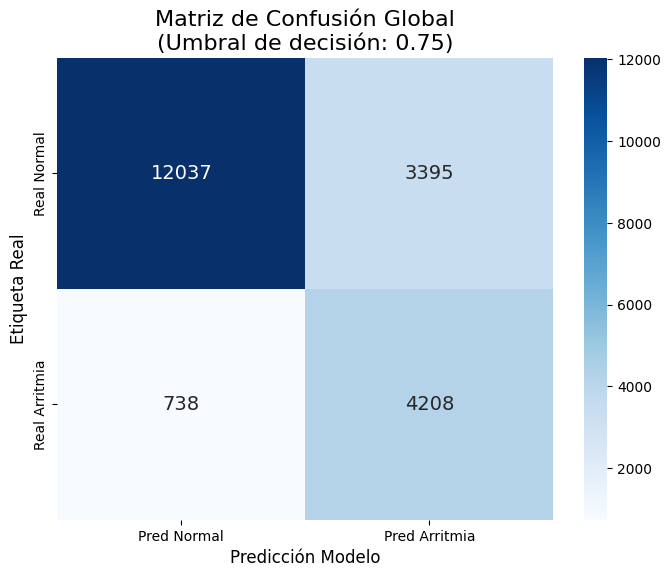

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import wfdb
from scipy.signal import find_peaks

def validar_como_raspberry_rapido(registros_test, modelo, umbral=0.5):
    """
    Simula la ejecución en tiempo real pero procesando por lotes para velocidad.
    Permite ajustar el umbral de decisión.
    """
    y_real_total = []
    y_pred_total = []

    print(f"--- INICIANDO VALIDACIÓN RÁPIDA (Umbral: {umbral}) ---")

    for record_id in registros_test:
        print(f"Procesando Paciente {record_id}...", end=" ")

        # 1. Cargar y Filtrar
        try:
            record = wfdb.rdrecord(record_id, pn_dir='mitdb')
            # Asegúrate de que 'filtro_bandpass' y 'FS' están definidos en celdas anteriores
            signal = filtro_bandpass(record.p_signal[:, 0], fs=record.fs)
        except Exception as e:
            print(f"Error cargando {record_id}: {e}")
            continue

        # 2. Detectar picos (Simulación sensor)
        # distance=int(FS*0.4) evita picos pegados (menos de 400ms)
        peaks, _ = find_peaks(signal, distance=int(FS*0.4), prominence=0.5)

        # 3. PREPARAR EL LOTE (BATCH)
        segmentos_paciente = []
        indices_validos = []

        for peak in peaks:
            start = peak - (WINDOW_SIZE // 2)
            end = peak + (WINDOW_SIZE // 2)

            # Chequeo de bordes
            if start < 0 or end > len(signal): continue

            segment = signal[start:end]

            # Chequeo de señal plana/invalida
            if np.std(segment) < 0.001: continue

            # Normalización (CRUCIAL: Z-Score individual)
            segment = (segment - np.mean(segment)) / np.std(segment)
            segmentos_paciente.append(segment)
            indices_validos.append(peak)

        if not segmentos_paciente:
            print("Sin latidos válidos.")
            continue

        # Convertir a array numpy para predicción masiva
        X_batch = np.array(segmentos_paciente)

        # 4. PREDICCIÓN MASIVA (Velocidad x100)
        preds_batch = modelo.predict(X_batch, verbose=0, batch_size=256)

        # 5. Cargar Ground Truth para comparar
        ann = wfdb.rdann(record_id, 'atr', pn_dir='mitdb')
        real_peaks = ann.sample
        real_symbols = ann.symbol

        # 6. ASIGNAR ETIQUETAS
        for i, peak in enumerate(indices_validos):
            prob = preds_batch[i][0]

            # APLICAR UMBRAL DINÁMICO
            pred_label = 1 if prob > umbral else 0

            # Buscar coincidencia con anotación real (ventana de tolerancia 30 muestras)
            idx_closest = np.abs(real_peaks - peak).argmin()
            distancia = np.abs(real_peaks[idx_closest] - peak)

            if distancia < 30: # Si hay una etiqueta real cerca
                symbol = real_symbols[idx_closest]
                if symbol in ['+', '~', '!', '[', ']', '|', '"']: continue

                real_label = 0 if symbol in NORMAL_SYMBOLS else 1

                y_real_total.append(real_label)
                y_pred_total.append(pred_label)

        print("Ok.")

    # --- VISUALIZACIÓN DE RESULTADOS ---
    print("\n" + "="*40)
    print(f"REPORTE FINAL (Umbral > {umbral})")
    print("="*40)

    # Reporte de texto
    print(classification_report(y_real_total, y_pred_total, target_names=['Normal', 'Arritmia']))

    # Matriz de Confusión Gráfica
    cm = confusion_matrix(y_real_total, y_pred_total)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Pred Normal', 'Pred Arritmia'],
                yticklabels=['Real Normal', 'Real Arritmia'],
                annot_kws={"size": 14})

    plt.title(f'Matriz de Confusión Global\n(Umbral de decisión: {umbral})', fontsize=16)
    plt.ylabel('Etiqueta Real', fontsize=12)
    plt.xlabel('Predicción Modelo', fontsize=12)
    plt.show()

# --- EJEMPLO DE USO ---
# Prueba con diferentes umbrales para buscar el óptimo
validar_como_raspberry_rapido(registros_test, model, umbral=0.75)

### 11. Ejecución de Validación Rápida con Umbral por Defecto

Ejecutamos la función de validación rápida sin especificar un umbral, lo que por defecto utiliza el valor de 0.5. Esto nos permite comparar el rendimiento del modelo con y sin el ajuste manual del umbral de decisión.

In [ ]:
validar_como_raspberry_rapido(registros_test, model)

--- INICIANDO VALIDACIÓN RÁPIDA ---
Procesando Paciente 102... Ok. (2187 latidos)
Procesando Paciente 104... Ok. (2234 latidos)
Procesando Paciente 115... Ok. (1952 latidos)
Procesando Paciente 117... Ok. (1534 latidos)
Procesando Paciente 207... Ok. (2003 latidos)
Procesando Paciente 209... Ok. (2874 latidos)
Procesando Paciente 214... Ok. (2259 latidos)
Procesando Paciente 222... Ok. (2240 latidos)
Procesando Paciente 230... Ok. (2255 latidos)
Procesando Paciente 234... Ok. (2752 latidos)

--- REPORTE FINAL OPTIMIZADO ---
              precision    recall  f1-score   support

           0       0.95      0.61      0.75     15432
           1       0.43      0.91      0.58      4946

    accuracy                           0.69     20378
   macro avg       0.69      0.76      0.67     20378
weighted avg       0.83      0.69      0.71     20378



### 12. Inclusión del Intervalo RR como Característica Adicional

Para mejorar la precisión del modelo, se añade el intervalo RR (tiempo entre latidos consecutivos) como una característica adicional. Esto es fundamental para detectar arritmias que dependen no solo de la forma del latido, sino también de su ritmo. La función `crear_dataset_con_ritmo` se encarga de calcular y añadir esta característica a los segmentos de ECG, manteniendo el aumento de datos con Jitter.

In [ ]:
import numpy as np
import wfdb
import random
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.model_selection import train_test_split

# --- CONFIGURACIÓN ---
FS = 360
WINDOW_SIZE = int(0.6 * FS)
NORMAL_SYMBOLS = ['N', 'L', 'R', 'e', 'j']

# --- FUNCIONES AUXILIARES NECESARIAS ---
def filtro_bandpass(data, lowcut=0.5, highcut=40.0, fs=360, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

def desplazamiento_aleatorio(segmento, max_shift=10):
    """Mueve el latido a izquierda o derecha rellenando bordes"""
    shift = np.random.randint(-max_shift, max_shift)
    if shift == 0: return segmento

    segmento_desplazado = np.roll(segmento, shift)

    # Corregir los bordes que quedaron "dando la vuelta" por np.roll
    if shift > 0:
        segmento_desplazado[:shift] = segmento_desplazado[shift]
    else:
        segmento_desplazado[shift:] = segmento_desplazado[shift-1]

    return segmento_desplazado

def crear_dataset_con_ritmo(lista_registros):
    X_list = []
    y_list = []

    print(f"Generando dataset con Ritmo (RR) para {len(lista_registros)} registros...")

    for record_id in lista_registros:
        try:
            record = wfdb.rdrecord(record_id, pn_dir='mitdb')
            annotation = wfdb.rdann(record_id, 'atr', pn_dir='mitdb')

            # Filtrado
            signal = filtro_bandpass(record.p_signal[:, 0], fs=record.fs)

            # Recorrer latidos
            for i, sample in enumerate(annotation.sample):
                symbol = annotation.symbol[i]
                if symbol in ['+', '~', '!', '[', ']', '|', '"']: continue

                label = 0 if symbol in NORMAL_SYMBOLS else 1

                # --- CALCULAR INTERVALO RR ---
                if i > 0:
                    prev_sample = annotation.sample[i-1]
                    rr_interval = sample - prev_sample
                    rr_seconds = rr_interval / FS
                else:
                    rr_seconds = 0.85 # Valor promedio

                # Limitar valores extremos (si hay cortes de señal)
                if rr_seconds > 2.5: rr_seconds = 2.5

                # Recortar ventana
                start = sample - (WINDOW_SIZE // 2)
                end = sample + (WINDOW_SIZE // 2)
                if start < 0 or end > len(signal): continue

                segment = signal[start:end]
                if np.std(segment) < 0.001: continue # Señal plana

                # Normalizar forma de onda
                segment_norm = (segment - np.mean(segment)) / np.std(segment)

                # --- FUSIÓN: FORMA (216) + RITMO (1) = 217 ---
                segment_con_rr = np.append(segment_norm, rr_seconds)

                # Guardar datos
                if label == 1:
                    X_list.append(segment_con_rr)
                    y_list.append(1)
                else:
                    # Guardar normal original
                    X_list.append(segment_con_rr)
                    y_list.append(0)

                    # Data Augmentation: Jitter + RR
                    # El RR no cambia aunque movamos el latido unos ms
                    if random.random() < 0.5:
                        seg_jitter = desplazamiento_aleatorio(segment_norm, max_shift=7)
                        seg_jitter_rr = np.append(seg_jitter, rr_seconds)
                        X_list.append(seg_jitter_rr)
                        y_list.append(0)

        except Exception as e:
            print(f"Error procesando registro {record_id}: {e}")
            # Importante: Imprimimos el error pero seguimos con el siguiente
            continue

    X = np.array(X_list)
    y = np.array(y_list)

    # Balanceo (Downsampling de normales)
    if len(y) > 0:
        idx_0 = np.where(y == 0)[0]
        idx_1 = np.where(y == 1)[0]
        n_samples = min(len(idx_0), len(idx_1))

        if n_samples > 0:
            idx_0_sel = np.random.choice(idx_0, n_samples, replace=False)
            idx_1_sel = np.random.choice(idx_1, n_samples, replace=False)

            indices = np.concatenate([idx_0_sel, idx_1_sel])
            np.random.shuffle(indices)

            return X[indices], y[indices]

    return X, y

# --- GENERAR NUEVOS DATOS ---
if 'registros_train' not in globals():
    # Si por error se reinicia el entorno, definimos una lista segura
    print("Variable registros_train no encontrada. Usando lista por defecto.")
    registros_train = ['100', '101', '103', '105', '106', '108', '109', '111', '112', '113', '114', '116', '118', '119', '121', '122', '123', '124', '200', '201', '202', '203', '205', '208', '210', '212', '213', '215', '219', '220', '221', '223', '228', '231', '232', '233']

X_train_rr, y_train_rr = crear_dataset_con_ritmo(registros_train)

if len(X_train_rr) > 0:
    X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(X_train_rr, y_train_rr, test_size=0.15, random_state=42)
    print(f"\n¡ÉXITO! Nuevo Dataset con RR creado.")
    print(f"Dimensiones entrada: {X_train_final.shape}") # Debería ser (N, 217)
else:
    print("Error crítico: El dataset está vacío.")

Generando dataset con Ritmo (RR) para 37 registros...

¡ÉXITO! Nuevo Dataset con RR creado.
Dimensiones entrada: (19908, 217)


### 13. Entrenamiento del Modelo con Forma de Onda y Ritmo (RR)

Entrenamos un nuevo modelo con el dataset que ahora incluye tanto la forma de onda del latido como el intervalo RR. La arquitectura del MLP es la misma, pero el modelo ahora tiene más información para tomar decisiones. Los *callbacks* y los pesos de clase se mantienen para asegurar un entrenamiento robusto y enfocado en la detección de arritmias.

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

def construir_mlp_robusto(input_dim):
    model = Sequential([
        # Capa de entrada
        Dense(128, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(), # Normaliza batch a batch, ayuda mucho con ECG
        Dropout(0.4),

        # Capas ocultas
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        Dense(32, activation='relu'),
        Dropout(0.2),

        # Salida
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model_rr = construir_mlp_robusto(X_train_final.shape[1])

callbacks = [
    EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    ModelCheckpoint('modelo_con_ritmo.keras', save_best_only=True),
    ReduceLROnPlateau(factor=0.5, patience=3)
]

# ENTRENAMIENTO EQUILIBRADO (Pesos suaves)
pesos_suaves = {0: 1.0, 1: 1.5}

print("Entrenando modelo con información de ritmo...")
history = model_rr.fit(
    X_train_final, y_train_final,
    validation_data=(X_val_final, y_val_final),
    epochs=40,
    batch_size=64,
    class_weight=pesos_suaves,
    callbacks=callbacks
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Entrenando modelo con información de ritmo...
Epoch 1/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8290 - loss: 0.4546 - val_accuracy: 0.9522 - val_loss: 0.1322 - learning_rate: 0.0010
Epoch 2/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9309 - loss: 0.2195 - val_accuracy: 0.9570 - val_loss: 0.1160 - learning_rate: 0.0010
Epoch 3/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9440 - loss: 0.1953 - val_accuracy: 0.9650 - val_loss: 0.1021 - learning_rate: 0.0010
Epoch 4/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9493 - loss: 0.1791 - val_accuracy: 0.9630 - val_loss: 0.0980 - learning_rate: 0.0010
Epoch 5/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9516 - loss: 0.1654 - val_accuracy: 0.9684 - val_loss: 0.0920 - learning_rate: 0.0010
Epoch 6/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9585 - loss: 0.1436 - val_accuracy: 0.9636 - val_loss: 0.0903 - learning_rate: 0.0010
Epoch 7/40
312/312 ━━━━━━━━━━━━━━━━━━━━ 

### 14. Validación del Modelo con Característica de Ritmo (RR)

Se realiza una nueva validación del modelo, esta vez utilizando la función `validar_raspberry_con_ritmo` que considera la característica del intervalo RR. Este paso es crucial para evaluar si la inclusión del ritmo mejora el rendimiento en la detección de arritmias, y se puede ajustar el umbral de decisión para optimizar la sensibilidad y especificidad.

--- VALIDACIÓN CON RITMO (Umbral: 0.85) ---
Paciente 102... Ok.
Paciente 104... Ok.
Paciente 115... Ok.
Paciente 117... Ok.
Paciente 207... Ok.
Paciente 209... Ok.
Paciente 214... Ok.
Paciente 222... Ok.
Paciente 230... Ok.
Paciente 234... Ok.

RESULTADOS MODELO CON RITMO (RR):
              precision    recall  f1-score   support

      Normal       0.93      0.89      0.91     15432
    Arritmia       0.70      0.80      0.75      4946

    accuracy                           0.87     20378
   macro avg       0.82      0.85      0.83     20378
weighted avg       0.88      0.87      0.87     20378



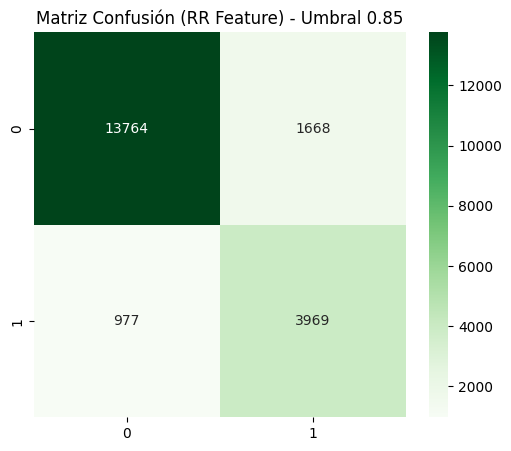

In [ ]:
def validar_raspberry_con_ritmo(registros_test, modelo, umbral=0.75):
    y_real = []
    y_pred = []

    print(f"--- VALIDACIÓN CON RITMO (Umbral: {umbral}) ---")

    for record_id in registros_test:
        print(f"Paciente {record_id}...", end=" ")

        try:
            record = wfdb.rdrecord(record_id, pn_dir='mitdb')
            signal = filtro_bandpass(record.p_signal[:, 0], fs=record.fs)

            # 1. Detectar TODOS los picos del registro
            peaks, _ = find_peaks(signal, distance=int(FS*0.4), prominence=0.5)

            inputs_batch = []
            indices_validos = []

            # 2. Iterar y construir características (Forma + RR)
            for i, peak in enumerate(peaks):
                # Calcular RR basándonos en el pico ANTERIOR DETECTADO
                if i > 0:
                    rr_samples = peaks[i] - peaks[i-1]
                    rr_seconds = rr_samples / FS
                else:
                    rr_seconds = 0.85 # Default primer latido

                # Limitar RR por seguridad
                if rr_seconds > 2.5: rr_seconds = 2.5

                # Recortar ventana
                start = peak - (WINDOW_SIZE // 2)
                end = peak + (WINDOW_SIZE // 2)
                if start < 0 or end > len(signal): continue

                segment = signal[start:end]
                if np.std(segment) < 0.001: continue

                # Normalizar
                segment_norm = (segment - np.mean(segment)) / np.std(segment)

                # AÑADIR RR AL FINAL
                input_vector = np.append(segment_norm, rr_seconds)

                inputs_batch.append(input_vector)
                indices_validos.append(peak)

            if not inputs_batch: continue

            # 3. Predicción por lotes
            X_batch = np.array(inputs_batch)
            preds = modelo.predict(X_batch, verbose=0, batch_size=512)

            # 4. Comparar con Ground Truth
            ann = wfdb.rdann(record_id, 'atr', pn_dir='mitdb')
            real_peaks = ann.sample
            real_symbols = ann.symbol

            for i, peak in enumerate(indices_validos):
                prob = preds[i][0]
                pred_label = 1 if prob > umbral else 0

                # Buscar etiqueta real
                idx = np.abs(real_peaks - peak).argmin()
                if np.abs(real_peaks[idx] - peak) < 30:
                    sym = real_symbols[idx]
                    if sym in ['+', '~', '!', '[', ']', '|', '"']: continue
                    true_label = 0 if sym in NORMAL_SYMBOLS else 1

                    y_real.append(true_label)
                    y_pred.append(pred_label)

            print("Ok.")

        except Exception as e:
            print(f"Error {e}")

    # Reporte
    print("\nRESULTADOS MODELO CON RITMO (RR):")
    print(classification_report(y_real, y_pred, target_names=['Normal', 'Arritmia']))

    cm = confusion_matrix(y_real, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.title(f'Matriz Confusión (RR Feature) - Umbral {umbral}')
    plt.show()

# Ejecutar validación
validar_raspberry_con_ritmo(registros_test, model_rr, umbral=0.85)

### 15. Validación con Base de Datos Externa (INCART)

Para garantizar la robustez y generalización del modelo, se realiza una validación cruzada con una base de datos de ECG completamente diferente: INCART. Esta base de datos tiene una frecuencia de muestreo distinta a la de MIT-BIH, por lo que se implementa un *resampling* para adaptar las señales a la frecuencia esperada por el modelo. Este es un paso crítico para asegurar que el modelo se desempeñe bien en escenarios del mundo real con datos variados.

--- INICIANDO VALIDACIÓN EXTERNA: INCART DATABASE (Umbral: 0.65) ---
Adaptando señales de 257Hz a 360Hz...
Procesando INCART I01... Ok.
Procesando INCART I02... Ok.
Procesando INCART I03... Ok.
Procesando INCART I04... Ok.
Procesando INCART I05... Ok.
Procesando INCART I06... Ok.
Procesando INCART I07... Ok.
Procesando INCART I08... Ok.
Procesando INCART I09... Ok.
Procesando INCART I10... Ok.
Procesando INCART I11... Ok.
Procesando INCART I12... Ok.
Procesando INCART I13... Ok.
Procesando INCART I14... Ok.
Procesando INCART I15... Ok.

 RESULTADOS VALIDACIÓN CRUZADA (INCART) - Umbral 0.65
              precision    recall  f1-score   support

      Normal       0.99      0.78      0.87     28706
    Arritmia       0.08      0.67      0.15       874

    accuracy                           0.78     29580
   macro avg       0.54      0.72      0.51     29580
weighted avg       0.96      0.78      0.85     29580



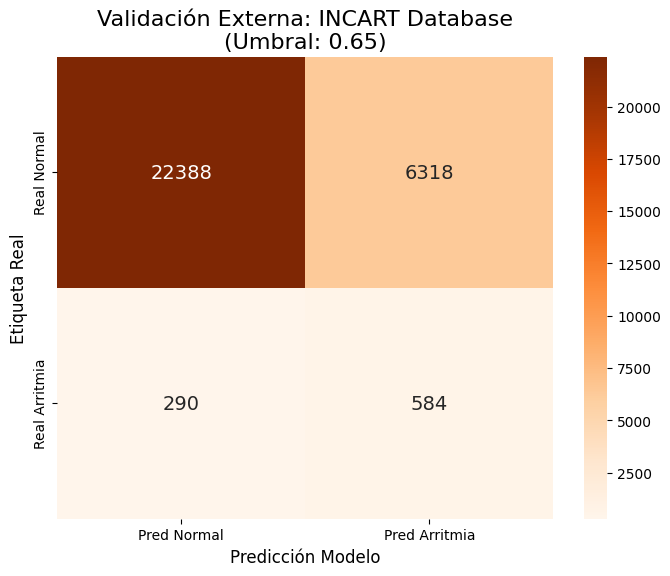

In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import resample, find_peaks
from sklearn.metrics import classification_report, confusion_matrix

# --- CONFIGURACIÓN ---
FS_MODELO = 360   # Frecuencia que espera tu modelo (MIT-BIH)
FS_INCART = 257   # Frecuencia original de INCART
WINDOW_SIZE = int(0.6 * FS_MODELO) # 216 muestras (en escala 360Hz)
UMBRAL_FINAL = 0.85 # Umbral ganador

def validar_incart_completa(modelo, umbral=0.85, num_registros=10):
    print(f"--- INICIANDO VALIDACIÓN EXTERNA: INCART DATABASE (Umbral: {umbral}) ---")
    print(f"Adaptando señales de {FS_INCART}Hz a {FS_MODELO}Hz...")

    y_real_total = []
    y_pred_total = []

    # Obtener lista de registros de INCART
    try:
        records_incart = wfdb.get_record_list('incartdb')
    except:
        # Lista manual de backup por si falla la conexión a PhysioNet
        records_incart = [str(i) for i in range(1, 76)]

    # Validamos con los primeros 'num_registros' para no eternizarnos
    for rec_id in records_incart[:num_registros]:
        print(f"Procesando INCART {rec_id}...", end=" ")

        try:
            # 1. Cargar Registro
            record = wfdb.rdrecord(rec_id, pn_dir='incartdb')
            annotation = wfdb.rdann(rec_id, 'atr', pn_dir='incartdb')

            # 2. Seleccionar Lead I
            idx_lead = 0
            if 'II' in record.sig_name:
                idx_lead = record.sig_name.index('I')
            elif len(record.sig_name) > 1:
                idx_lead = 1 # Por defecto en 12-leads suele ser el primer canal

            signal_original = record.p_signal[:, idx_lead]

            # 3. RESAMPLING (La parte crítica)
            # Convertimos la señal de 257Hz a 360Hz
            num_samples_new = int(len(signal_original) * FS_MODELO / FS_INCART)
            signal_360 = resample(signal_original, num_samples_new)

            # Ajustar las anotaciones a la nueva escala de tiempo
            ratio = FS_MODELO / FS_INCART
            real_peaks_360 = (annotation.sample * ratio).astype(int)
            real_symbols = annotation.symbol

            # 4. FILTRADO (Sobre la señal ya escalada a 360)
            signal_final = filtro_bandpass(signal_360, fs=FS_MODELO)

            # 5. DETECCIÓN DE PICOS (Simulación Raspberry)
            peaks_detectados, _ = find_peaks(signal_final, distance=int(FS_MODELO*0.4), prominence=0.5)

            inputs_batch = []
            indices_validos = []

            # 6. EXTRACCIÓN DE CARACTERÍSTICAS (Forma + RR)
            for i, peak in enumerate(peaks_detectados):
                # Calculamos RR en segundos (usando FS_MODELO porque la señal ya es 360)
                if i > 0:
                    rr_samples = peaks_detectados[i] - peaks_detectados[i-1]
                    rr_seconds = rr_samples / FS_MODELO
                else:
                    rr_seconds = 0.85

                if rr_seconds > 2.5: rr_seconds = 2.5

                # Recorte
                start = peak - (WINDOW_SIZE // 2)
                end = peak + (WINDOW_SIZE // 2)

                if start < 0 or end > len(signal_final): continue

                segment = signal_final[start:end]
                if np.std(segment) < 0.001: continue

                # Normalización
                segment = (segment - np.mean(segment)) / np.std(segment)

                # Input Vector (216 + 1 RR)
                input_vector = np.append(segment, rr_seconds)
                inputs_batch.append(input_vector)
                indices_validos.append(peak)

            if not inputs_batch: continue

            # 7. PREDICCIÓN
            X_batch = np.array(inputs_batch)
            preds = modelo.predict(X_batch, verbose=0, batch_size=512)

            # 8. COMPARACIÓN GROUND TRUTH
            for i, peak in enumerate(indices_validos):
                prob = preds[i][0]
                pred_label = 1 if prob > umbral else 0

                # Buscar etiqueta real más cercana (en coordenadas 360Hz)
                idx = np.abs(real_peaks_360 - peak).argmin()
                if np.abs(real_peaks_360[idx] - peak) < 30: # Tolerancia
                    sym = real_symbols[idx]
                    if sym in ['+', '~', '!', '[', ']', '|', '"']: continue

                    real_label = 0 if sym in NORMAL_SYMBOLS else 1
                    y_real_total.append(real_label)
                    y_pred_total.append(pred_label)

            print("Ok.")

        except Exception as e:
            print(f"Skip {rec_id}: {e}")

    # --- REPORTE VISUAL---
    print("\n" + "="*50)
    print(f" RESULTADOS VALIDACIÓN CRUZADA (INCART) - Umbral {umbral}")
    print("="*50)

    print(classification_report(y_real_total, y_pred_total, target_names=['Normal', 'Arritmia']))

    cm = confusion_matrix(y_real_total, y_pred_total)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['Pred Normal', 'Pred Arritmia'],
                yticklabels=['Real Normal', 'Real Arritmia'],
                annot_kws={"size": 14})

    plt.title(f'Validación Externa: INCART Database\n(Umbral: {umbral})', fontsize=16)
    plt.ylabel('Etiqueta Real', fontsize=12)
    plt.xlabel('Predicción Modelo', fontsize=12)
    plt.show()

# EJECUTAR CON EL MODELO FINAL (RR)
# Usamos el umbral elegido con la base de datos MIT, y realizamos diferentes pruebas
validar_incart_completa(model_rr, umbral=0.65, num_registros=15)

### 16. Conversión a TensorFlow Lite para Despliegue en Borde

El último paso es convertir el modelo entrenado a un formato optimizado para dispositivos de borde, TensorFlow Lite (`.tflite`). Esta conversión reduce significativamente el tamaño del modelo y lo hace más eficiente para la inferencia en tiempo real en plataformas como la Raspberry Pi, que tienen recursos computacionales limitados. Se aplican optimizaciones por defecto para mejorar aún más el rendimiento.

In [ ]:
import tensorflow as tf
from google.colab import files

print("--- INICIANDO CONVERSIÓN A TFLITE ---")

# 1. Crear el convertidor desde el modelo actual
converter = tf.lite.TFLiteConverter.from_keras_model(model_rr)

# 2. Aplicar optimizaciones (hace que vaya más rápido en Raspberry Pi)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# 3. Convertir el modelo
tflite_model = converter.convert()

# 4. Guardar el archivo en el disco de Colab
nombre_archivo = 'modelo_ecg_edge.tflite'
with open(nombre_archivo, 'wb') as f:
    f.write(tflite_model)

print(f"✅ Conversión exitosa. Archivo creado: {nombre_archivo}")

# 5. Descargar automáticamente al PC
print("Descargando archivo...")
files.download(nombre_archivo)

--- INICIANDO CONVERSIÓN A TFLITE ---
Saved artifact at '/tmp/tmpaqgypsya'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 217), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132399450207632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132399450208784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132399450207056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132399450206480: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132399450205712: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132399461243536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132399450206096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132399450208976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132399451752016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132399451752208: TensorSpec(shape=(), dtype=tf.resourc

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>